## Sinewave Function

### Importing basic libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MCMC_DZ.MCMC.Statistic_tools as Sts
import MCMC_DZ.MCMC.Visualization_tools as Vts
import os 
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
import MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions as PDs
from MCMC_DZ.BayesianInference.Likelihood_functions import Sinewave

### The pdf function

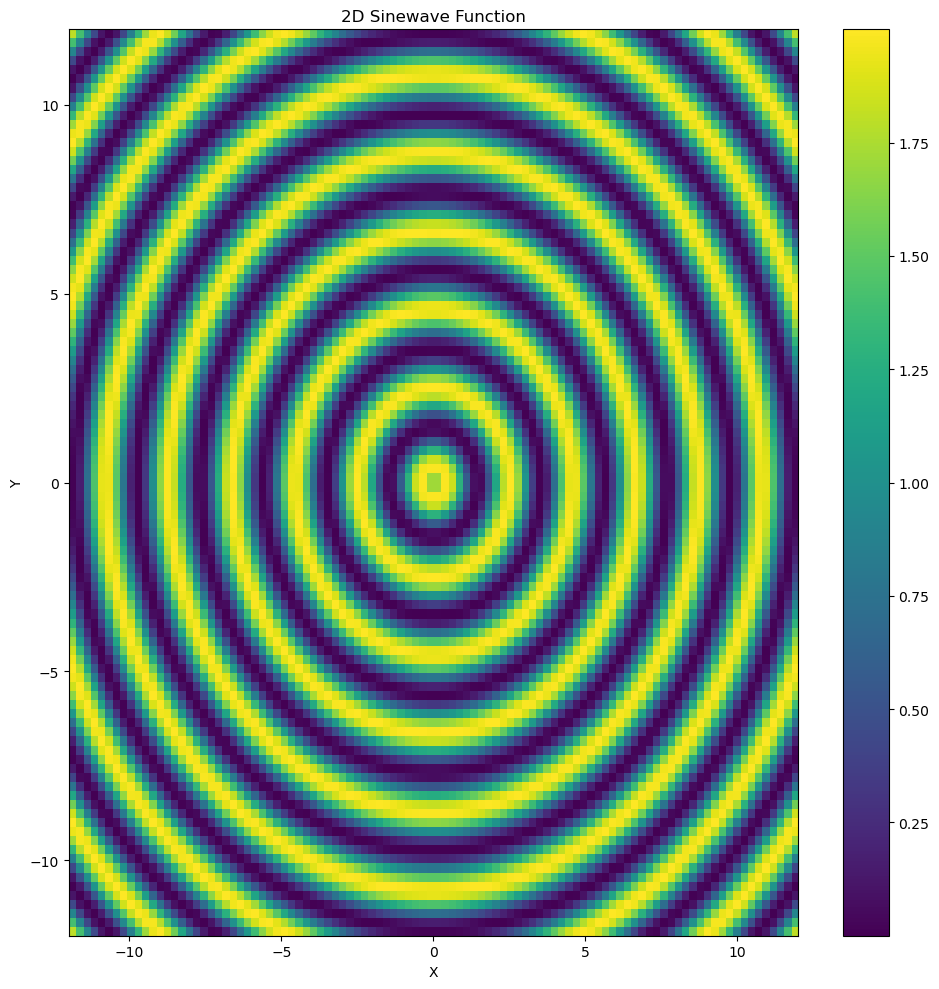

In [3]:
Data_range = np.array([[-12, 12], [-12, 12]])
SF = Sinewave.Sinewave_function([3, 2], Data_range)
Vts.Target_Distribution_Visualization(X_range=Data_range[0], Y_range=Data_range[1], Tar_Dis=SF.f, Func_name="2D Sinewave Function", alpha=1)

### Generating the Fake Data

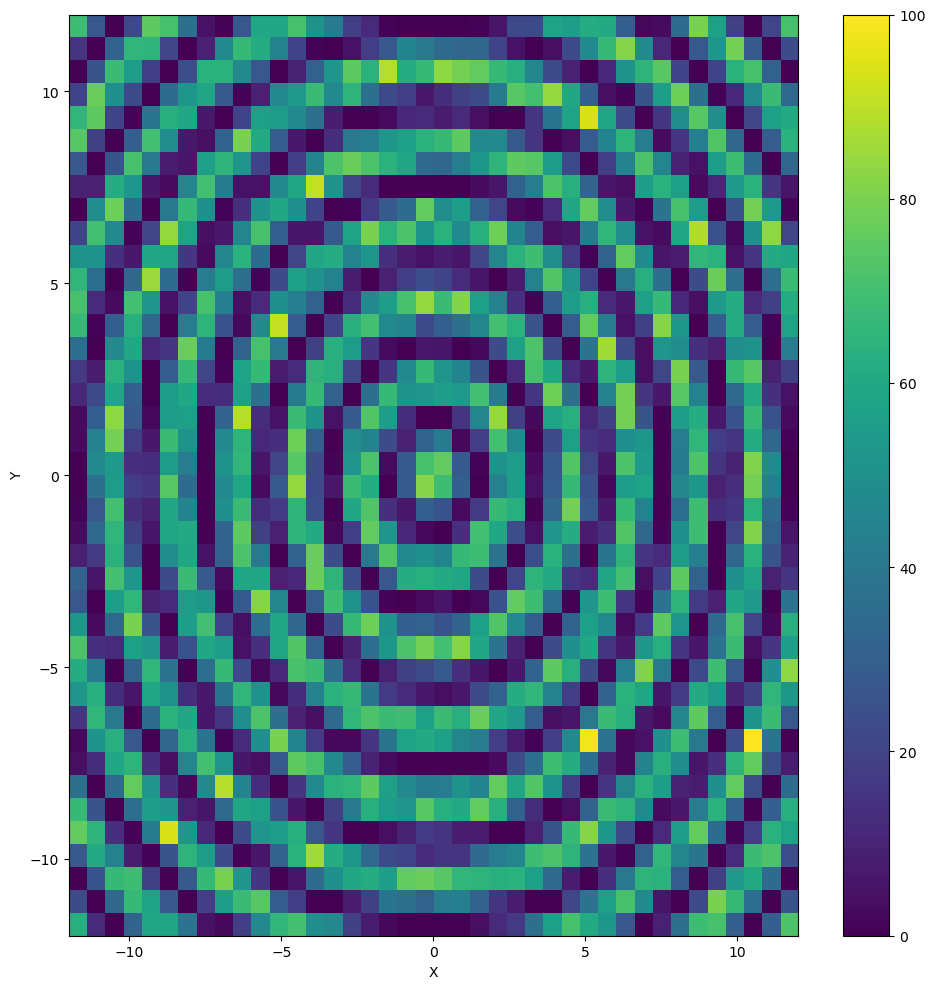

In [4]:
Data_range = np.array(Data_range)

SFFD_P = Sts.FakeDataGen2D_Poisson(SF.f, Data_range, 40, scaler=100)

Vts.PlotHeatmap(SFFD_P.x ,SFFD_P.y, SFFD_P.BinsValue.reshape(SFFD_P.x.shape), xlabel="X", ylabel="Y", zlabel="F(X,Y)")

### Generating the Likelihood Function

In [5]:
def Prior(params):
    if (0<params[0] and params[0]<10 and 0<=params[1] and params[1]<3):
        return 1
    else:
        return 0
SF_l = Sts.LikeliFuncGen(SFFD_P, SF, Prior)

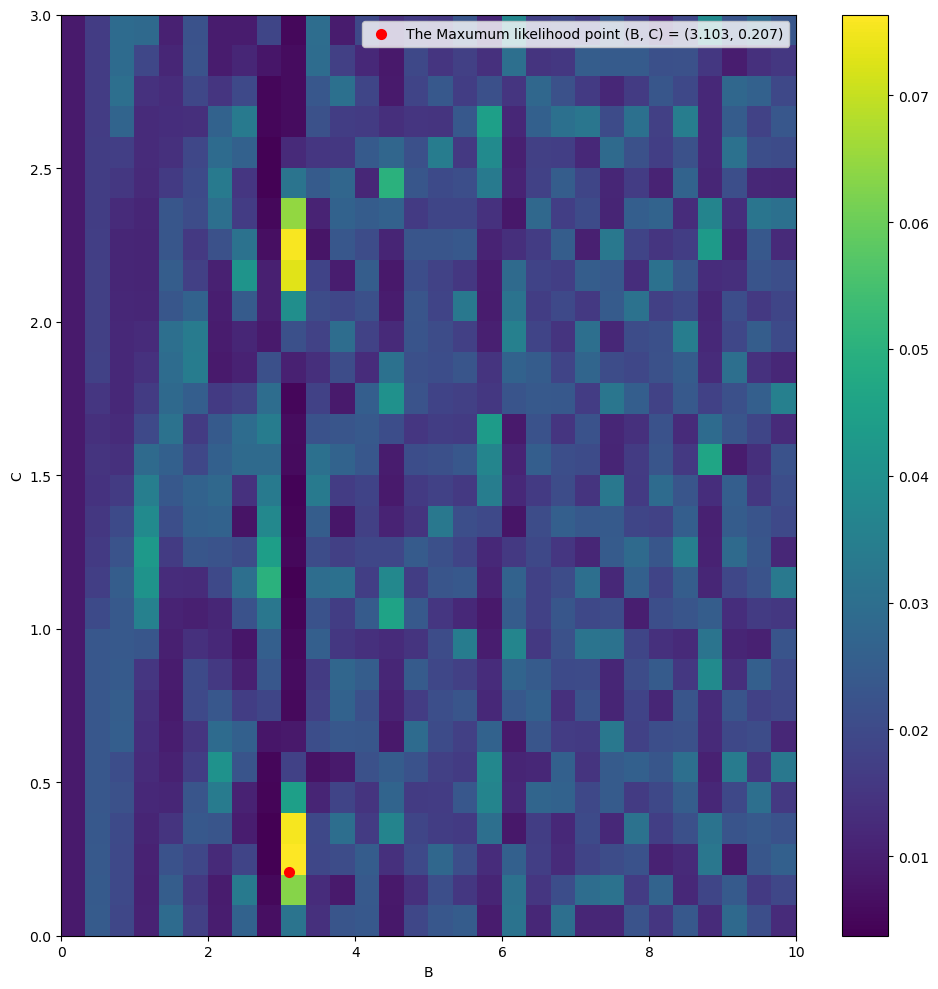

In [6]:
Bs = np.linspace(0, 10, 30)
Cs = np.linspace(0, 3, 30)
Bs, Cs = np.meshgrid(Bs, Cs)

Ls = []
for params in zip(Bs.flatten(), Cs.flatten()):
    Ls.append(SF_l.Likelihood(params))

Ls = np.asarray(Ls).reshape(Bs.shape)
Vts.PlotHeatmap(Bs, Cs, Ls, xlabel="B", ylabel="C", zlabel="l(B, C)", Plot_Max=True)

### Initializing the list to collect the outputs of the MCMC algorithm

In [9]:
Res = []

In [10]:
# Loading the pre outputs
data_folder = "Datas_Dian"
for name in os.listdir(data_folder):
    data_dir = os.path.join(data_folder, name)
    Res.append(Sts.Loading_Data(data_dir))

### Applying MCMC algorithm on the likelihood funciton

In [8]:
sd = [10, 1]
steps = 1000000
Prop_G = PDs.GaussianProposalDistribution(sd=sd, Dim=2)
MHMC_SF = MHMC(rho=SF_l.Posterior, log_likelihood=False)
Res_G_SF = MHMC_SF.generate(
    theta0=[0 for _ in range(2)], 
    ProposalFunction=Prop_G,
    steps=steps,
    OutputRunTime=100,
    MaxTime=3000
)
Res.append(Res_G_SF)

{'Thetas': array([[  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [  0.        ,   0.        ],
       [ -5.78600252,   1.65143654],
       [-30.05279495,   1.22252391],
       [-17.39343237,   0.35578351],
       [-17.39343237,   0.35578351],
       [-17.39343237,   0.35578351],
       [-21.83325196,  -0.07856777],
       [  0.22604886,   2.10821832],
       [  0.22604886,   2.10821832]]), 'ProposalFunction': 'GaussianProposalDistribution', 'PD_sd': [10, 1], 'Acceptance_Rate': 0.5, 'Run_Times': [0.014307300000002243]}


## Saving Data

In [10]:
k = -1
sd = Res[k]["PD_sd"]
Saving_dir = f"Datas_Dian/Res_G_SF(sd={sd}).npz"
Sts.Saving_Data(Res[k], FileName=Saving_dir)

### Visualizing the output of the MCMC algorithm

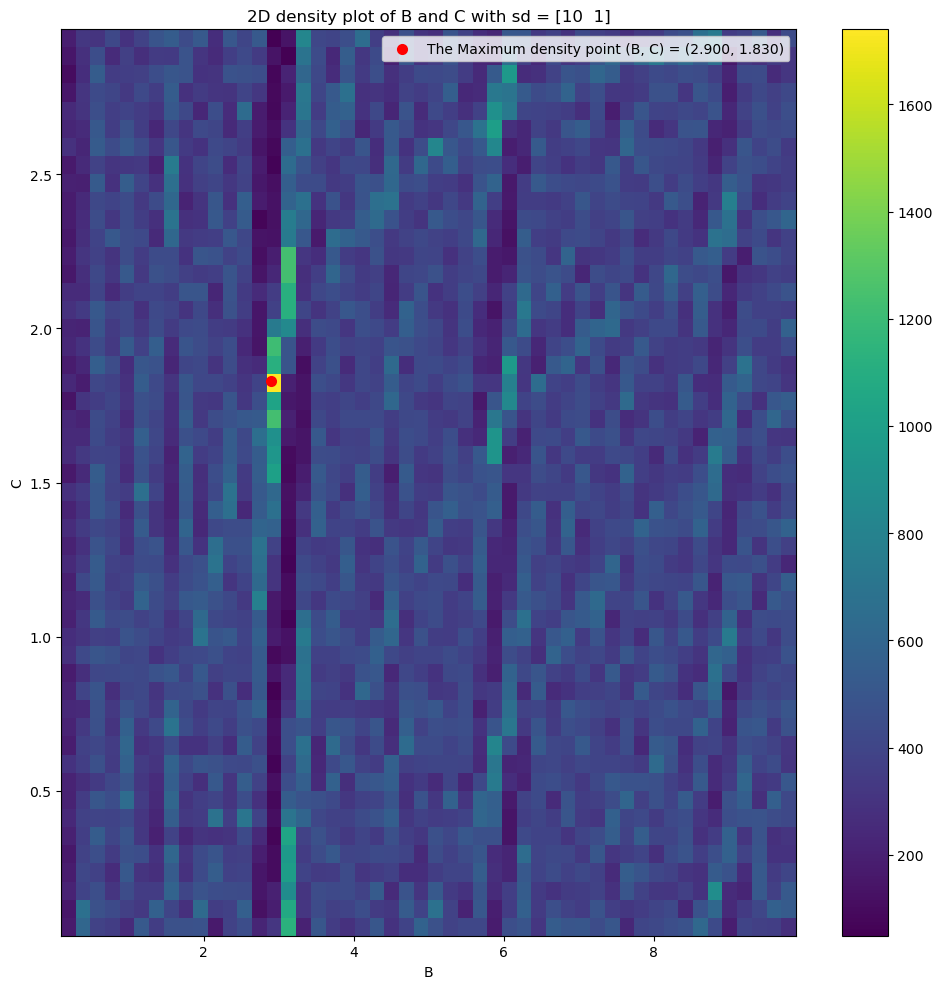

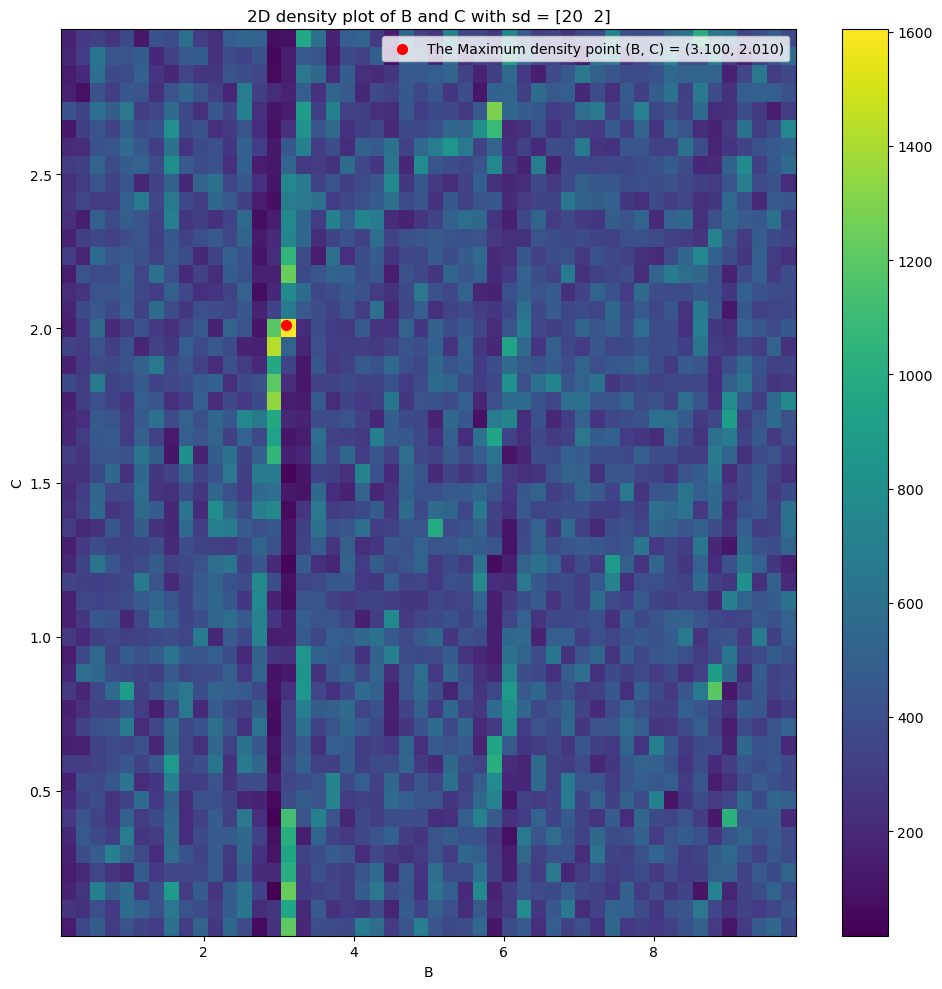

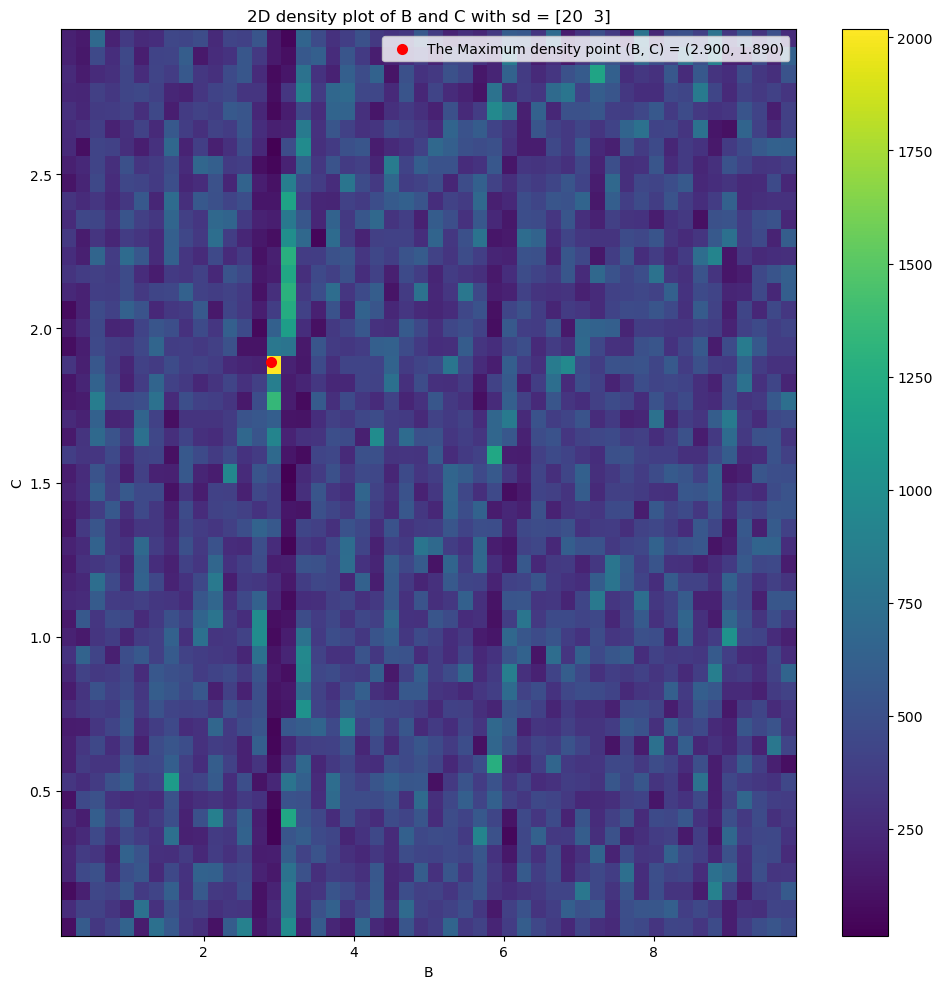

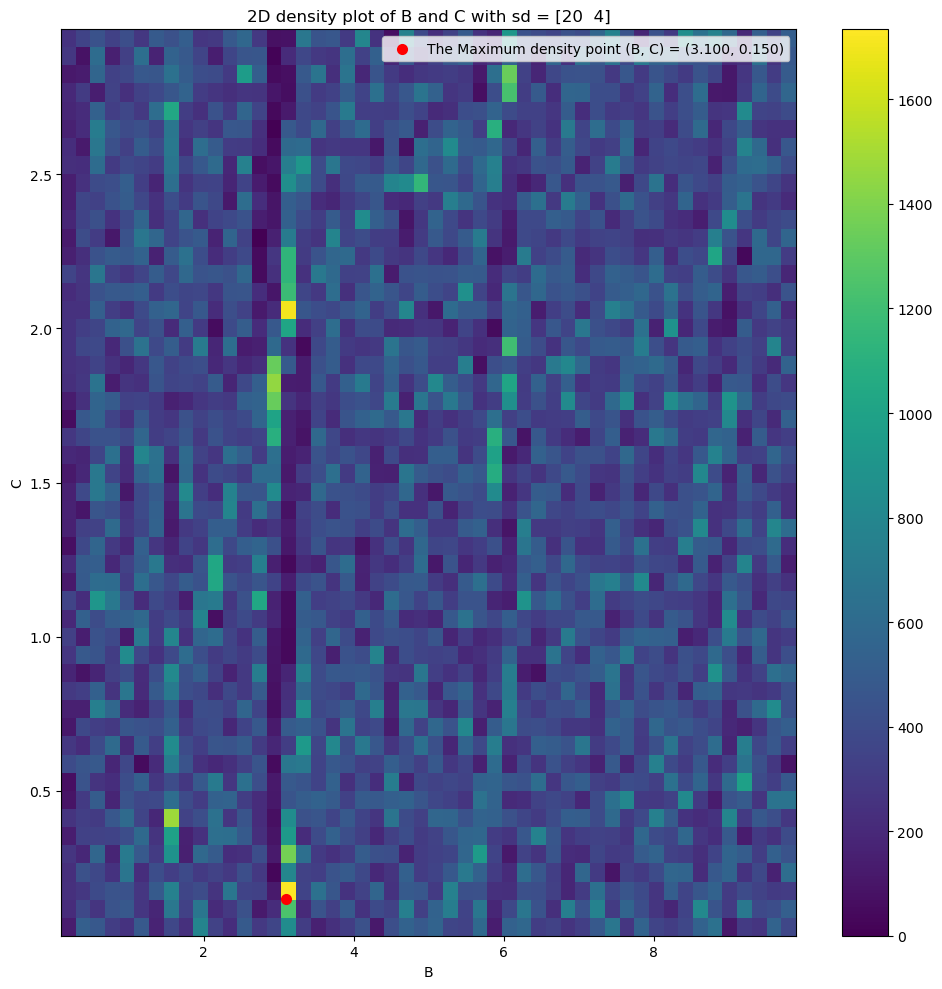

In [11]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    Vts.density_plot(
        Res_G_SF["Thetas"], 
        bins=50,
        burn_in=1000,
        credible_region=0,
        x_name="B",
        y_name="C",
        label = f" with sd = {sd}",
        alpha=1
    )

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\MCMC\Visualization_tools.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


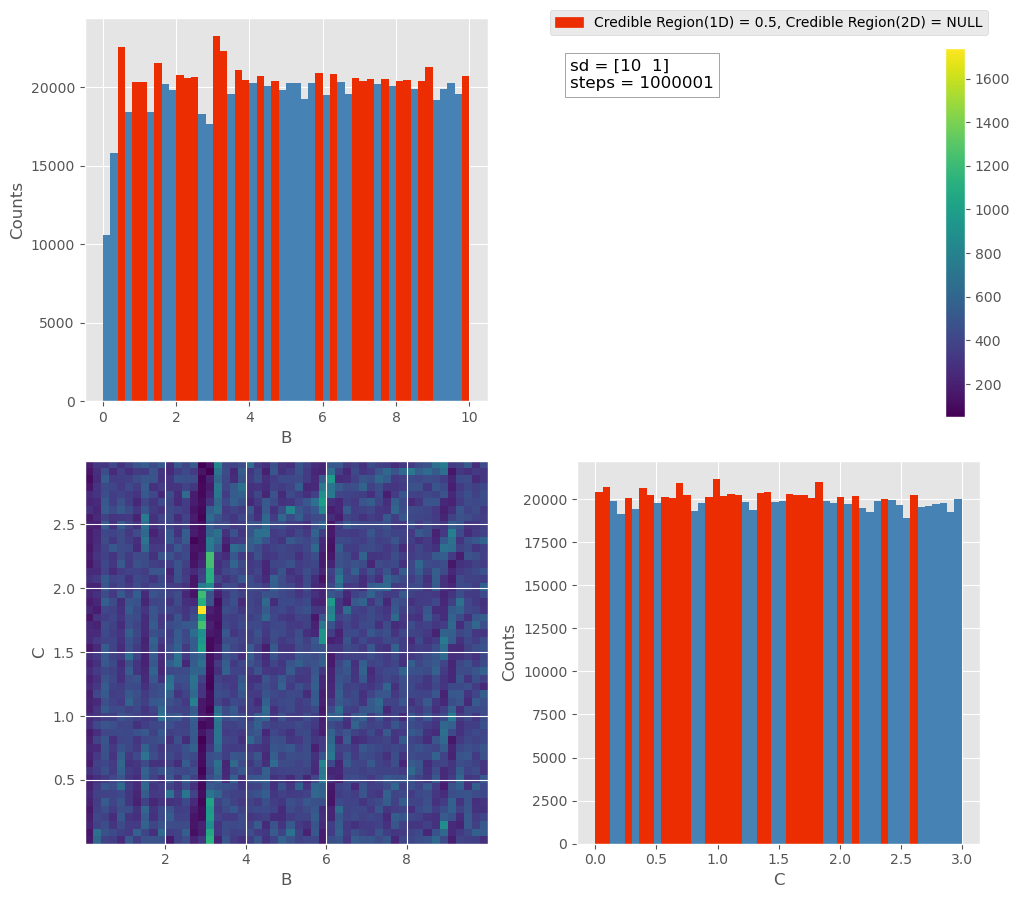

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\MCMC\Visualization_tools.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


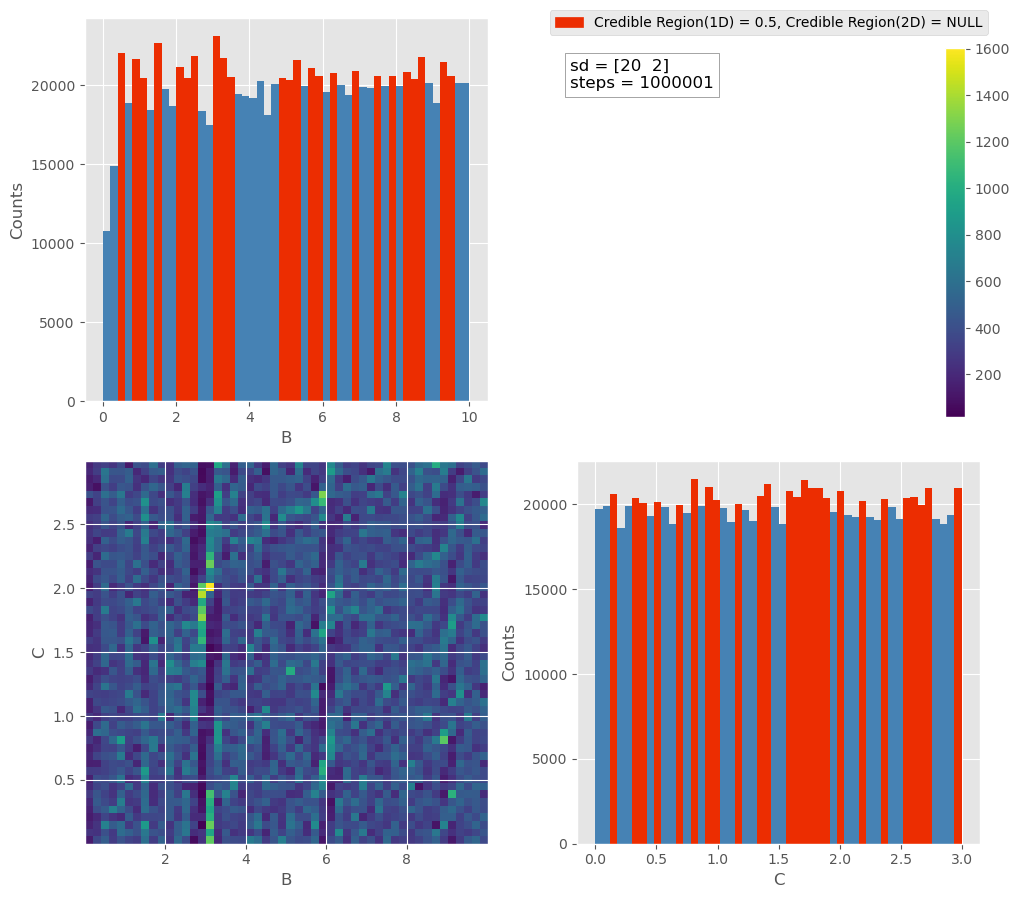

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\MCMC\Visualization_tools.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


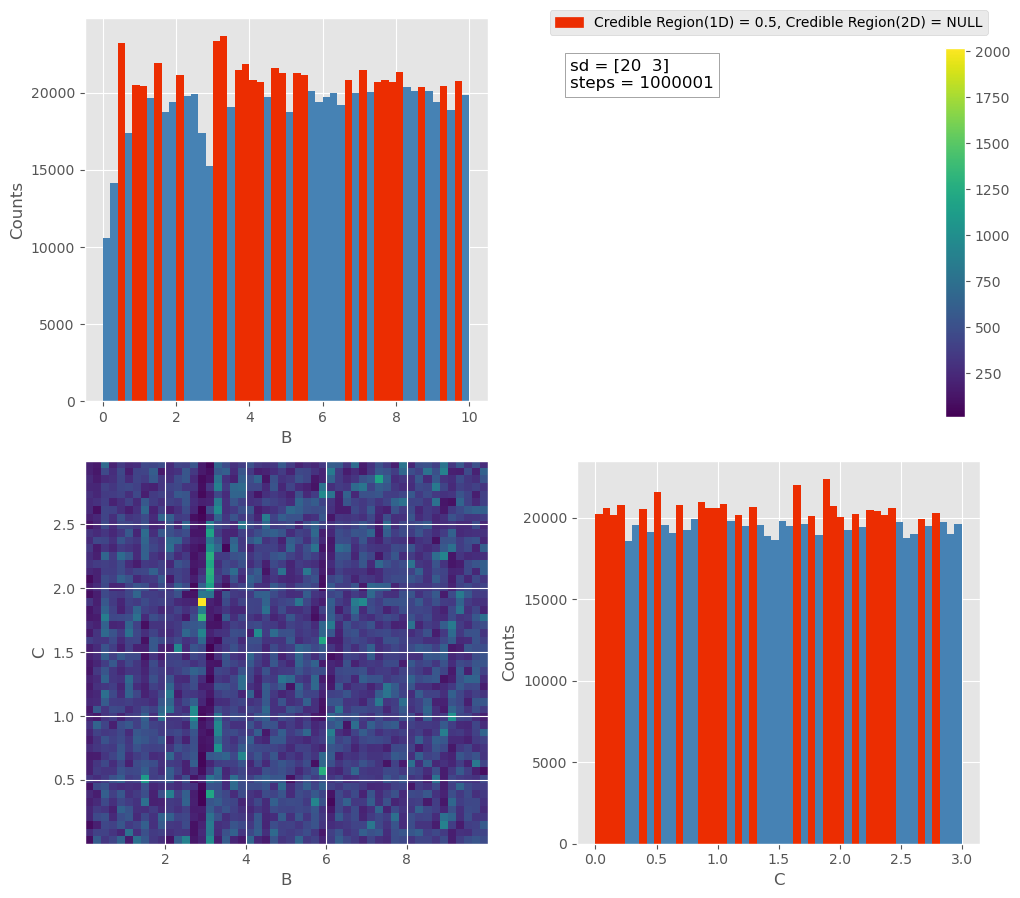

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\MCMC\Visualization_tools.py:250: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


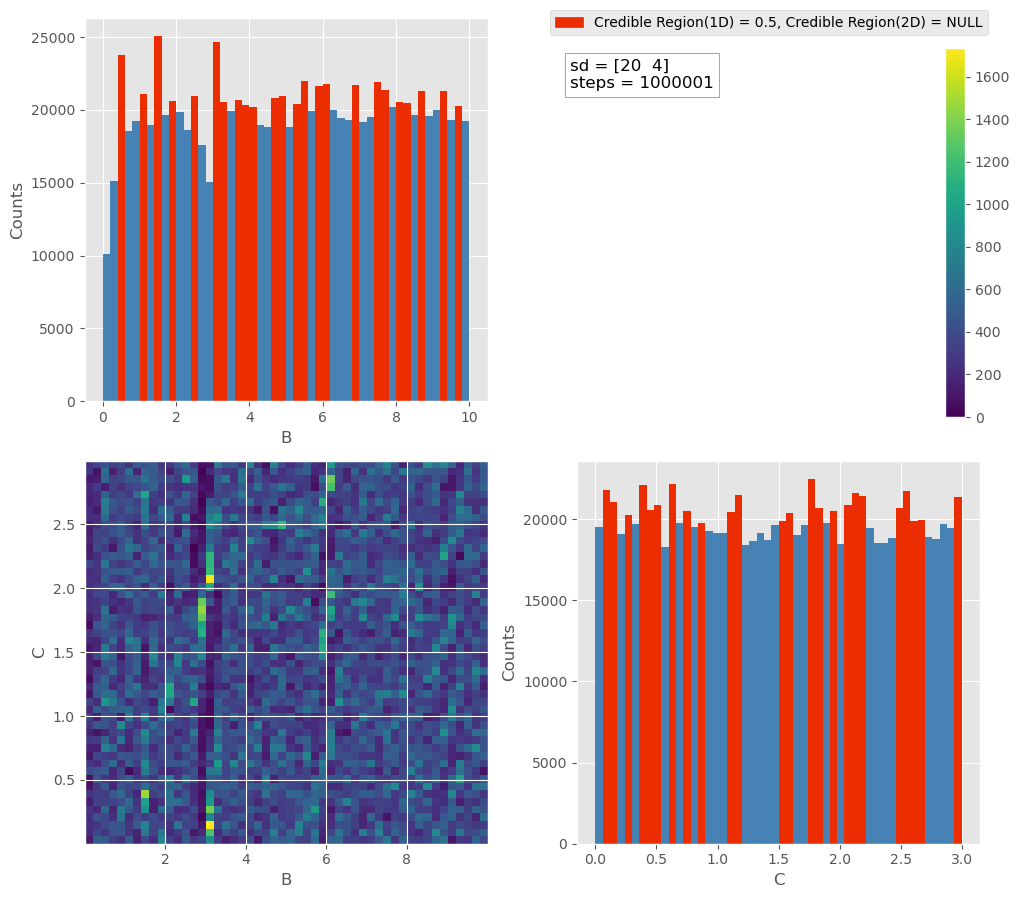

In [17]:
for Res_G_SF in Res:
    sd = Res_G_SF["PD_sd"]
    steps = Res_G_SF["Thetas"].shape[0]
    _ = Vts.density_plots(
        Res_G_SF["Thetas"],
        plot_axis=[0, 1],
        bins=50,
        burn_in=1000,
        axis_name=["B", "C"],
        cr_1D=0.5,
        cr_2D=0,
        information=f"sd = {sd}\nsteps = {steps}"
    )


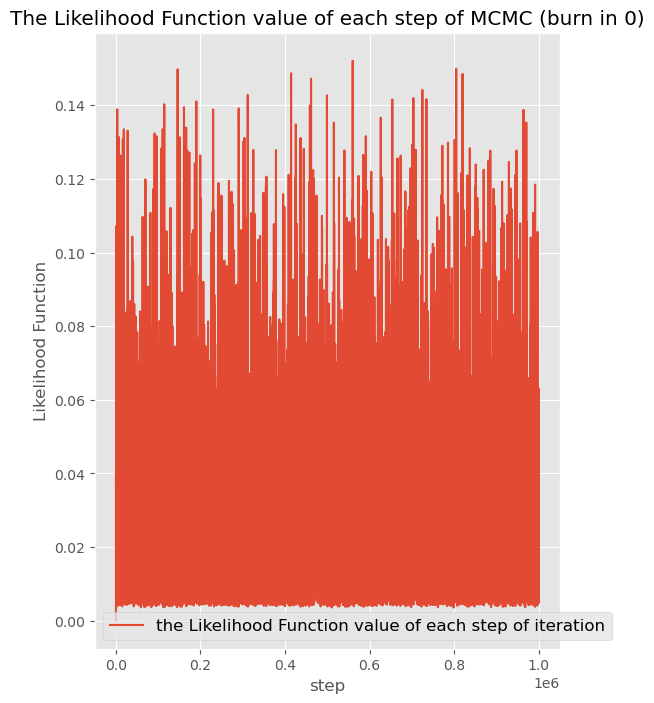

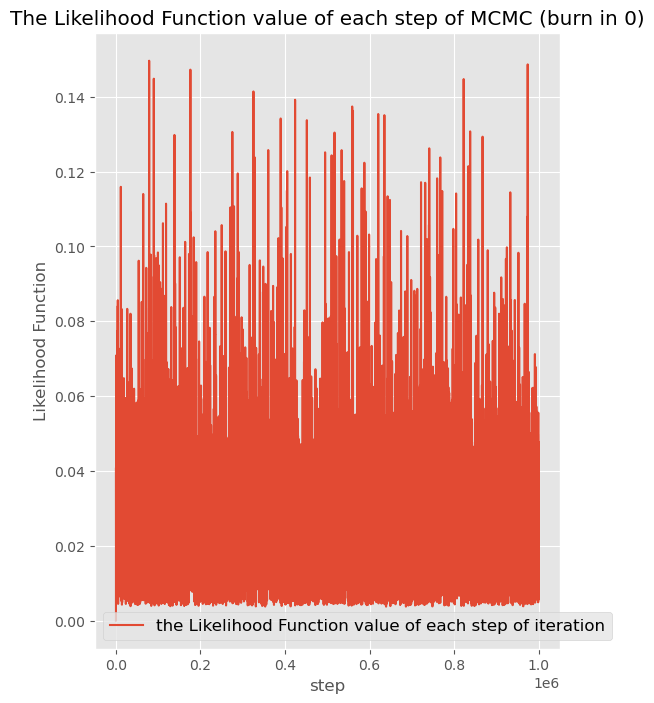

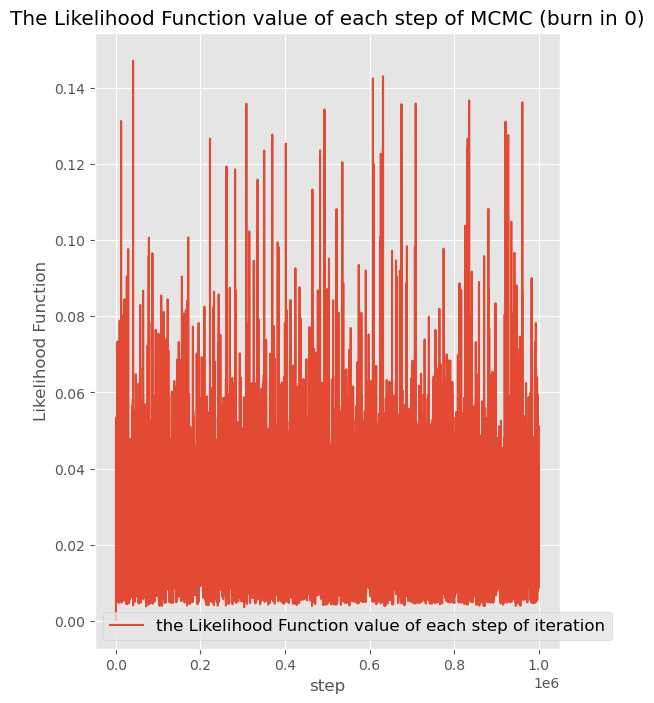

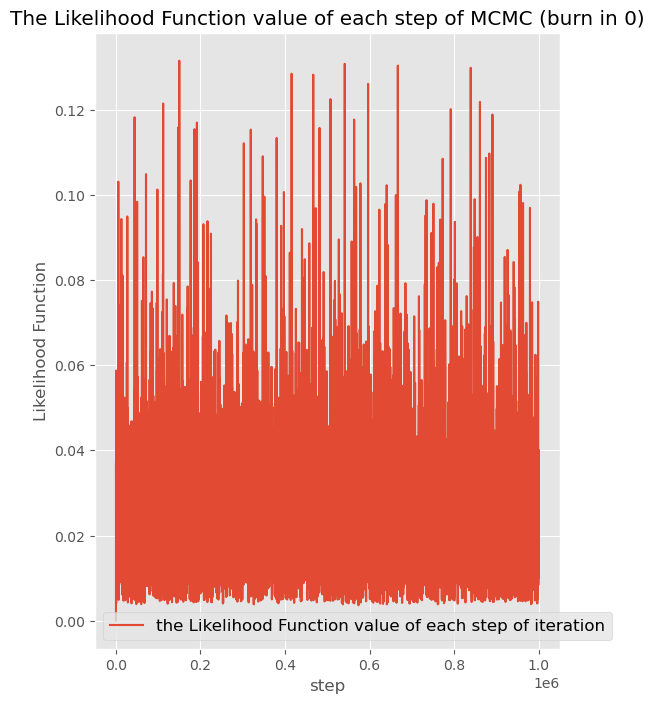

In [16]:
for Res_G_SF in Res:
    Vts.targetDis_step_plot(Res_G_SF["Thetas"], SF_l.Posterior, burn_in=0, target_type="Likelihood Function")

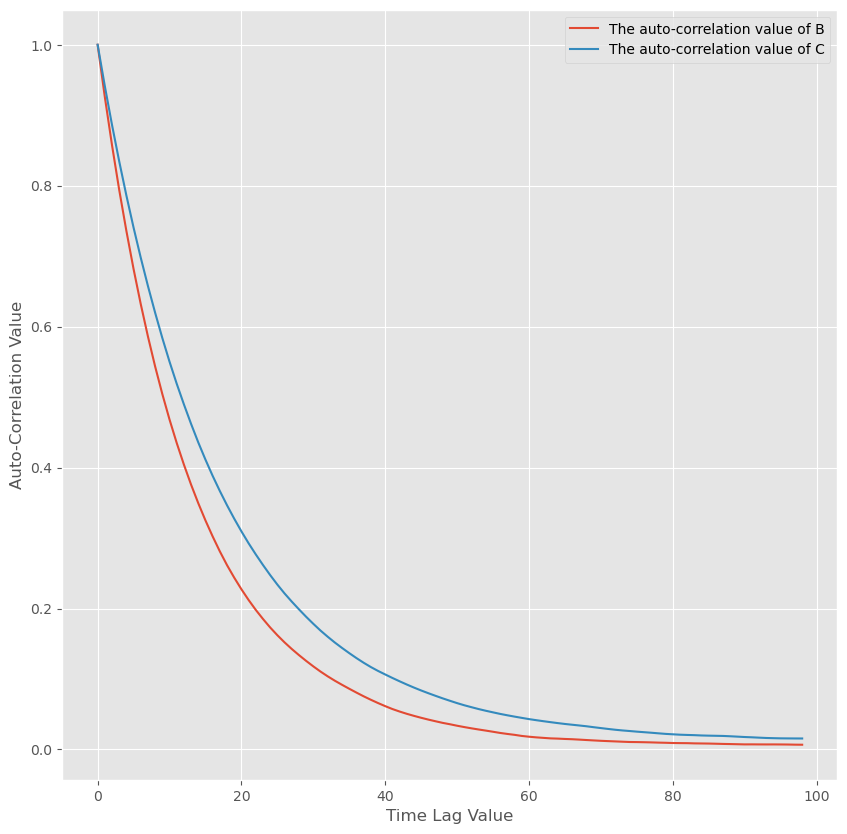

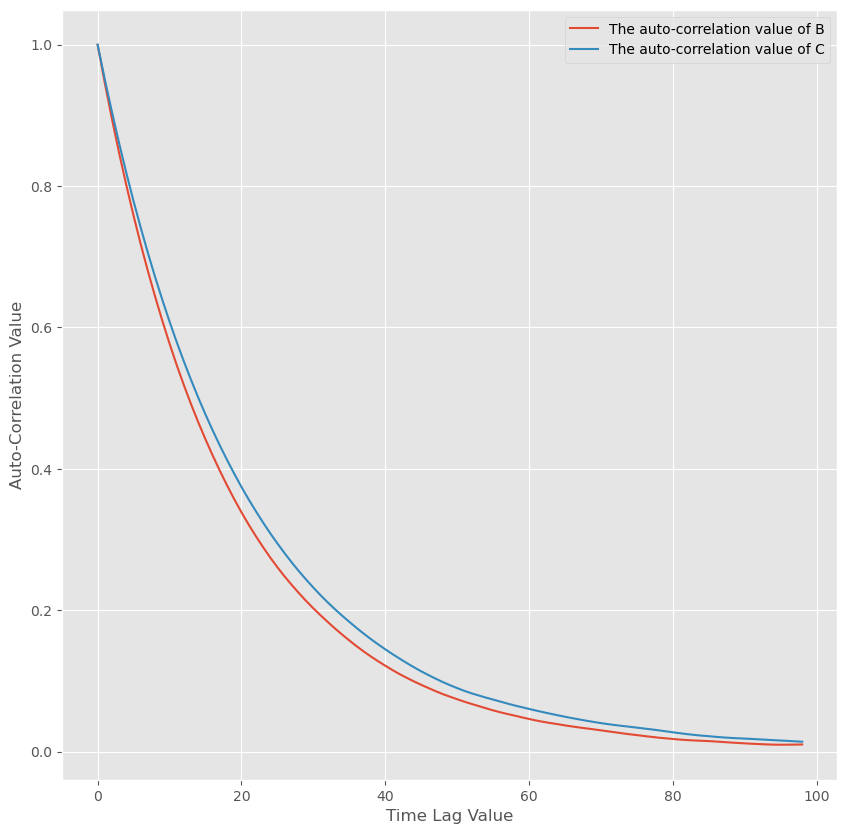

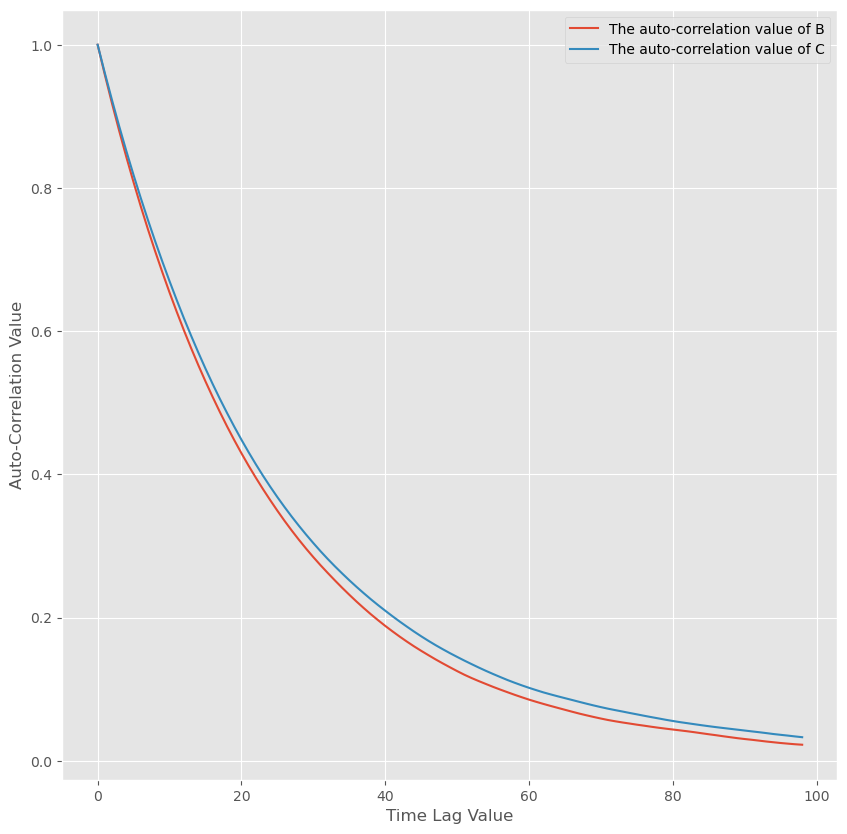

In [25]:
for Res_G_SF in Res:
    Vts.auto_corr_plot(Res_G_SF["Thetas"], [0,1], ["B", "C"], 100, [1000, steps])

### Testing Functions

In [29]:
Vts.UpdatingPlot(Data_range=[0, 200], Data=Res[0]["Thetas"])

### Hamiltonian MCMC

In [30]:
steps = 20000
Prop_H = PDs.HamiltonianProposalFunction(rho=SF_l.Posterior, epsilon=0.1, L=4)
MHMC_SF = MHMC(rho=Prop_H.U, log_likelihood=True)
Res_H_SF = MHMC_SF.generate(
    theta0=[1 for _ in range(2)], 
    qProb=Prop_H.log_qProb,
    qSamp=Prop_H.qSample,
    steps=steps,
    OutputRunTime=100,
    MaxTime=600
)

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\MCMC\MetropolisHastingMCMC\ProposalDistributions.py:228: RuntimeWarning:

divide by zero encountered in log

c:\Users\91464\OneDrive\桌面\GitHub\MResMCMC2023\MCMC_DZ\BayesianInference\Likelihood_functions\Sinewave.py:61: RuntimeWarning:

invalid value encountered in sin



KeyboardInterrupt: 

In [14]:
print(Res_H_SF["Run_Times"][-1])

57.278778026


In [15]:
Vts.density_plot(
    Res_H_SF["Thetas"], 
    bins=30,
    burn_in=100,
    credible_region=0,
    x_name="B",
    y_name="C",
    alpha=1
)

ValueError: autodetected range of [nan, nan] is not finite

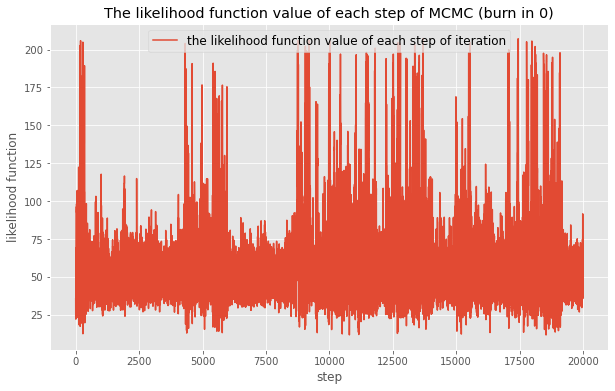

In [37]:
Vts.targetDis_step_plot(Thetas=Res_H_SF["Thetas"], rho=SF_l.Posterior, target_type="likelihood function", burn_in=0, figsize=(10,6))

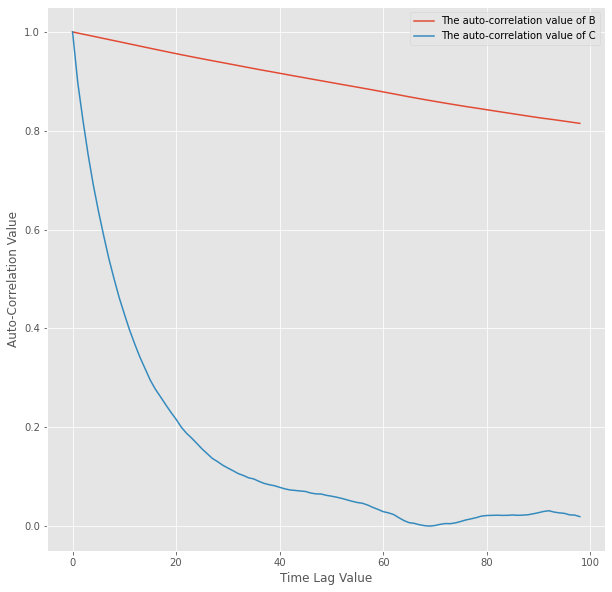

In [38]:
Vts.auto_corr_plot(Res_H_SF["Thetas"], [0,1], ["B", "C"], 100, [1000, 60000])

In [46]:
UpdatingPlot(Data_range=[0, 200], Data=Res_H_SF["Thetas"])

# Dfference Function

In [18]:
def density_ratioplot(Thetas, rho, bins, x_axis=0, y_axis=1, x_name="x", y_name="y", burn_in=0, alpha=1, label="", Save_fig=False, fig_name="density plot", Plot3D=False):
    """
    Plot an interactive 3D heatmap of a pair of dimensions from the input data.

    Arguments:
    Thetas (np.array): the value of parameters generated by the MCMC model
    bins (int): the number of bins of each histogram and heat map
    x_axis (int): the index of the x-axis to plot
    y_axis (int): the index of the y-axis to plot
    x_name (string): the name of the x-axis to plot
    y_name (string): the name of the y-axis to plot
    burn_in (int): the number of the data points want to "burn_in" for the graph
    credible_region (float): the size of the credible region in percent
    figsize (tuple): the size of the figure
    label (string): the label want to add to the plot
    Save_fig (bool): decide whether to save the output figure of the function
    fig_name (string): the saved figure name

    Returns:
    None
    """
    Thetas = np.asarray(Thetas)

    # prepare the data for the 2D histogram
    hist, xedges, yedges = np.histogram2d(Thetas[burn_in:, x_axis], Thetas[burn_in:, y_axis], bins=bins)
    xmid = 0.5*(xedges[1:] + xedges[:-1])
    ymid = 0.5*(yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xmid, ymid)

    Likeli = np.asarray([rho(np.asarray([x,y])) for (x,y) in zip(X.flatten(), Y.flatten())])
    Likeli = Likeli.reshape(X.shape)
    Likeli = (Likeli)
    hist = (hist.T) / Thetas.shape[0]
    # Calculate the Z axis value of the heat map
    Z = ((Likeli)/(hist))
    Z[hist==0] = 0
    Z = 2*(Z-np.min(Z))/np.max(Z-np.min(Z))

    if Plot3D:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        # plot the density
        # plot the density plot of the inputted data
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=alpha)
        # # Add contour plots
        # cset = ax.contour(X, Y, hist.T, zdir='z', offset=np.min(hist), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='x', offset=np.min(xedges), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='y', offset=np.max(yedges), cmap=plt.cm.coolwarm)

        fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"3D ratio plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel("ratio")
        ax.set_box_aspect([1, 1, 0.7])
        # ax.view_init(elev=-1.7, azim=-1.7)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()
    else:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        # plot the density plot of the inputted data
        ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto')

        fig.colorbar(ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"2D ratio plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()

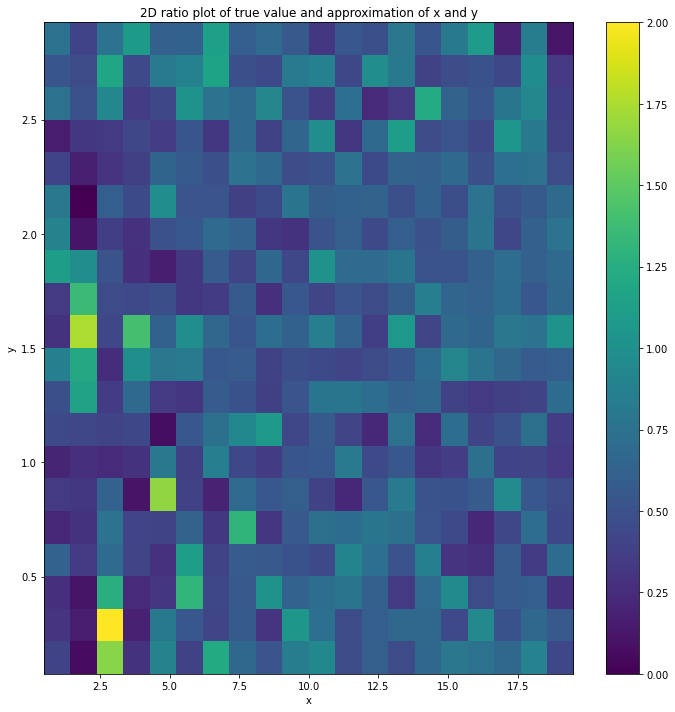

In [19]:
i = 2
density_ratioplot(
    Thetas=Res[i]["Thetas"][:70000],
    rho=SF_l.Posterior,
    bins=20
)